In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [17]:
path = Path('/kaggle/input/mnist/mnist_png')

In [18]:
training_path = path /'training'
print(training_path.ls())

[Path('/kaggle/input/mnist/mnist_png/training/7'), Path('/kaggle/input/mnist/mnist_png/training/2'), Path('/kaggle/input/mnist/mnist_png/training/5'), Path('/kaggle/input/mnist/mnist_png/training/8'), Path('/kaggle/input/mnist/mnist_png/training/0'), Path('/kaggle/input/mnist/mnist_png/training/3'), Path('/kaggle/input/mnist/mnist_png/training/1'), Path('/kaggle/input/mnist/mnist_png/training/4'), Path('/kaggle/input/mnist/mnist_png/training/9'), Path('/kaggle/input/mnist/mnist_png/training/6')]


In [19]:
testing_path = path / 'testing/9'
print(testing_path.ls())

[Path('/kaggle/input/mnist/mnist_png/testing/9/9292.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/6692.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/5106.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/2673.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/4358.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/1088.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/5100.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/7863.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/8841.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/2448.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/8426.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/9767.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/7236.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/9620.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/4319.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/9890.png'), Path('/kaggle/input/mnist/mnist_png/testing/9/5073.png'), Path('/kaggle

In [23]:
dls = ImageDataLoaders.from_folder(
    path,  
    valid_pct=0.2, 
    seed=42,  
    item_tfms=Resize(192),  
    batch_tfms=aug_transforms()
)

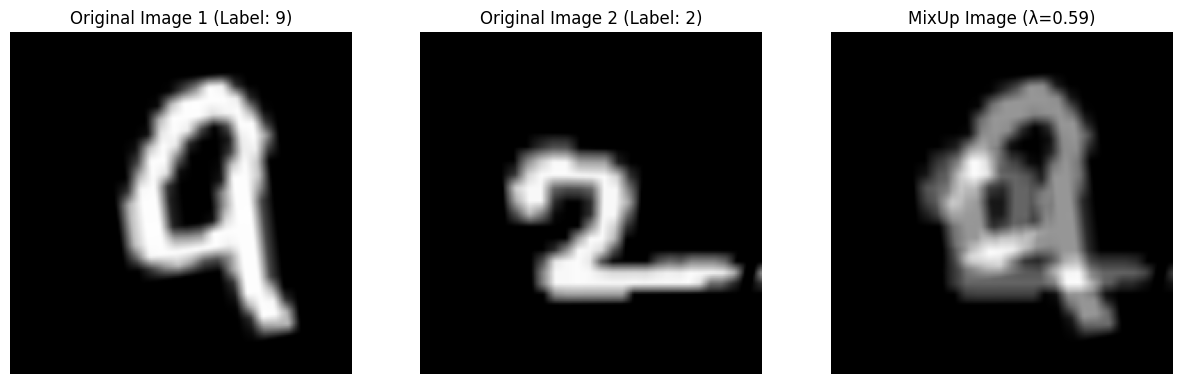

Label 1 (Smoothed): tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.9100])
Label 2 (Smoothed): tensor([0.0100, 0.0100, 0.9100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100])
MixUp Label: tensor([0.0100, 0.0100, 0.3759, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.5441])


In [34]:
import matplotlib.pyplot as plt
x_batch, y_batch = dls.one_batch()
y1 = y_batch[0].item()
y2 = y_batch[1].item()
lambda_ = np.random.uniform(0.2, 0.8)
mixup_image = lambda_ * x_batch[0] + (1 - lambda_) * x_batch[1]
num_classes = len(dls.vocab) if hasattr(dls, 'vocab') else dls.c
label1 = F.one_hot(torch.tensor(y1), num_classes=num_classes).float()
label2 = F.one_hot(torch.tensor(y2), num_classes=num_classes).float()
smooth_factor = 0.1
label1_smoothed = label1 * (1 - smooth_factor) + smooth_factor / num_classes
label2_smoothed = label2 * (1 - smooth_factor) + smooth_factor / num_classes
mixup_label = lambda_ * label1_smoothed + (1 - lambda_) * label2_smoothed
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(x_batch[0].cpu().permute(1, 2, 0))
axes[0].set_title(f"Original Image 1 (Label: {y1})")
axes[0].axis('off')
axes[1].imshow(x_batch[1].cpu().permute(1, 2, 0))
axes[1].set_title(f"Original Image 2 (Label: {y2})")
axes[1].axis('off')
axes[2].imshow(mixup_image.cpu().permute(1, 2, 0))
axes[2].set_title(f"MixUp Image (λ={lambda_:.2f})")
axes[2].axis('off')
plt.show()
print(f"Label 1 (Smoothed): {label1_smoothed}")
print(f"Label 2 (Smoothed): {label2_smoothed}")
print(f"MixUp Label: {mixup_label}")

In [8]:
learn = vision_learner(
    dls, 
    resnet18,  
    metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 216MB/s]


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(minimum=0.017378008365631102, steep=0.001737800776027143)

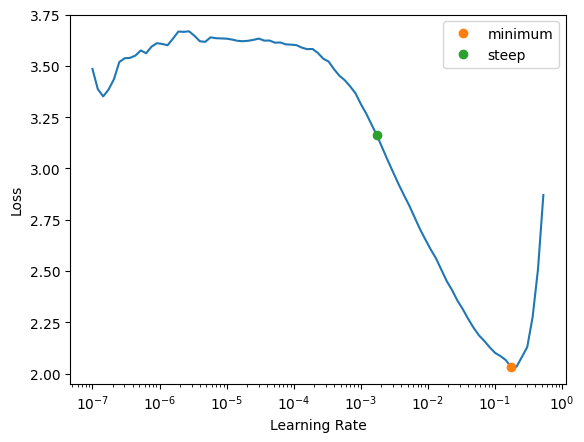

In [9]:
learn.lr_find(suggest_funcs=(minimum, steep))

In [10]:
class MixUp(MixHandler):
    def __init__(self, 
        alpha:float=.4
    ): 
        super().__init__(alpha)
    def before_batch(self):
        lam = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))

        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

In [11]:
learn = vision_learner(
    dls, 
    resnet18,  
    metrics=accuracy,
    loss_func=CrossEntropyLossFlat(label_smoothing=0.1),  # label smoothing
    cbs=MixUp()  )

In [12]:
def fit_one_cycle(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                  moms=None, cbs=None, reset_opt=False, start_epoch=0):
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
    scheds = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final),
              'mom': combined_cos(pct_start, *(self.moms if moms is None else moms))}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)

In [13]:
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)

In [14]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.253323,0.706178,0.939929,01:22


epoch,train_loss,valid_loss,accuracy,time
0,0.998375,0.563884,0.985714,01:43
1,0.953394,0.551016,0.987643,01:43
2,0.918592,0.537236,0.991357,01:44
3,0.909522,0.533044,0.991643,01:43
4,0.875377,0.529295,0.991571,01:43
5,0.860936,0.523351,0.993357,01:43
6,0.846324,0.519665,0.994429,01:42
7,0.840261,0.519652,0.993643,01:41
8,0.833575,0.518907,0.993857,01:41
9,0.837282,0.518394,0.993786,01:42


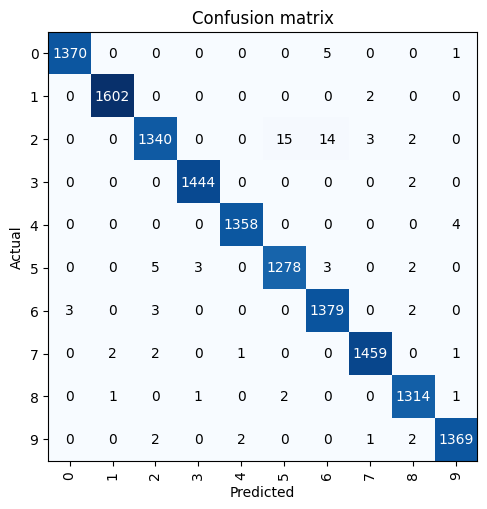

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))

In [16]:
learn.export('Handwritten_Digit_Recognizer.pkl')